<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/Update2_BTC_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

     |████████████████████████████████| 6.3 MB 8.2 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=5a3dd20dd482aad52b49283329643d4c3887c82487d34bcabc347f92d0783ad3
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Importing the Dataset & Exploring it

In [2]:
# Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '1y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: BTC-USD
You entered BTC-USD, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
356,2021-10-13,56038.257812,57688.660156,54370.972656,57401.097656,41684252783,0,0
357,2021-10-14,57372.832031,58478.734375,56957.074219,57321.523438,36615791366,0,0
358,2021-10-15,57345.902344,62757.128906,56868.144531,61593.949219,51780081801,0,0
359,2021-10-16,61609.527344,62274.476562,60206.121094,60892.179688,34250964237,0,0
360,2021-10-17,60887.652344,61645.523438,59164.468750,61553.617188,29032367511,0,0
361,2021-10-18,61548.804688,62614.660156,60012.757812,62026.078125,38055562075,0,0
362,2021-10-19,62043.164062,64434.535156,61622.933594,64261.992188,40471196346,0,0
363,2021-10-20,64284.585938,66930.390625,63610.675781,65992.835938,40788955582,0,0
364,2021-10-21,66002.234375,66600.546875,62117.410156,62210.171875,45908121370,0,0
365,2021-10-22,62424.953125,63715.023438,61576.941406,61883.996094,38845538304,0,0


In [3]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,366.000000,366.000000,366.000000,366.000000,3.660000e+02,366.0,366.0
mean,40121.184130,41359.110661,38795.546803,40249.824376,4.789230e+10,0.0,0.0
std,13777.820261,14092.359783,13398.735020,13752.904479,2.456526e+10,0.0,0.0
min,12801.635742,13015.961914,12717.093750,12931.539062,1.878799e+10,0.0,0.0
25%,32527.793457,33639.125977,31217.616699,32521.707520,3.318832e+10,0.0,0.0
50%,40340.693359,42201.810547,38809.861328,40549.972656,4.278877e+10,0.0,0.0
75%,49991.458008,51928.896484,48864.632812,50044.494141,5.851956e+10,0.0,0.0
max,66002.234375,66930.390625,63610.675781,65992.835938,3.509679e+11,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [4]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [5]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [6]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [7]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [8]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [37]:
for lag in [8, 16, 32, 64, 128]:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 8 lags: 0.5434
Hurst exponent with 16 lags: 0.5457
Hurst exponent with 32 lags: 0.5152
Hurst exponent with 64 lags: 0.5385
Hurst exponent with 128 lags: 0.5676


## Data Preparation for Facebook Prophet

In [14]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
361,2021-10-18,62026.078125
362,2021-10-19,64261.992188
363,2021-10-20,65992.835938
364,2021-10-21,62210.171875
365,2021-10-22,61883.996094


## Creating Facebook Prophet Model

In [22]:
m=Prophet(daily_seasonality=True)
m.fit(prophet_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


##Forecasting

In [29]:
periods = 30
future=m.make_future_dataframe(periods)

In [30]:
forecast=m.predict(future)

In [31]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-10-22,12184.329323,3845.353572,14200.499536,12184.329323,12184.329323,-2978.009804,-2978.009804,-2978.009804,-2930.496488,-2930.496488,-2930.496488,-47.513317,-47.513317,-47.513317,0.0,0.0,0.0,9206.319519
1,2020-10-23,12462.170139,4877.657853,15088.744661,12462.170139,12462.170139,-2675.027427,-2675.027427,-2675.027427,-2930.496488,-2930.496488,-2930.496488,255.469061,255.469061,255.469061,0.0,0.0,0.0,9787.142712
2,2020-10-24,12740.010956,4320.282549,14562.411995,12740.010956,12740.010956,-2811.971152,-2811.971152,-2811.971152,-2930.496488,-2930.496488,-2930.496488,118.525336,118.525336,118.525336,0.0,0.0,0.0,9928.039804
3,2020-10-25,13017.851772,5104.607791,15342.439429,13017.851772,13017.851772,-2911.471773,-2911.471773,-2911.471773,-2930.496488,-2930.496488,-2930.496488,19.024714,19.024714,19.024714,0.0,0.0,0.0,10106.379998
4,2020-10-26,13295.692588,5084.687103,15195.081401,13295.692588,13295.692588,-3041.727348,-3041.727348,-3041.727348,-2930.496488,-2930.496488,-2930.496488,-111.230860,-111.230860,-111.230860,0.0,0.0,0.0,10253.965240
5,2020-10-27,13573.533404,5071.282420,15316.662470,13573.533404,13573.533404,-3194.522240,-3194.522240,-3194.522240,-2930.496488,-2930.496488,-2930.496488,-264.025752,-264.025752,-264.025752,0.0,0.0,0.0,10379.011164
6,2020-10-28,13851.374220,6124.425541,16142.041521,13851.374220,13851.374220,-2900.745669,-2900.745669,-2900.745669,-2930.496488,-2930.496488,-2930.496488,29.750819,29.750819,29.750819,0.0,0.0,0.0,10950.628551
7,2020-10-29,14129.215036,5886.455268,16215.636896,14129.215036,14129.215036,-2978.009804,-2978.009804,-2978.009804,-2930.496488,-2930.496488,-2930.496488,-47.513317,-47.513317,-47.513317,0.0,0.0,0.0,11151.205232
8,2020-10-30,14407.055853,6372.811072,17026.001461,14407.055853,14407.055853,-2675.027427,-2675.027427,-2675.027427,-2930.496488,-2930.496488,-2930.496488,255.469061,255.469061,255.469061,0.0,0.0,0.0,11732.028426
9,2020-10-31,14684.896669,6680.118307,16863.170367,14684.896669,14684.896669,-2811.971152,-2811.971152,-2811.971152,-2930.496488,-2930.496488,-2930.496488,118.525336,118.525336,118.525336,0.0,0.0,0.0,11872.925517


In [32]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

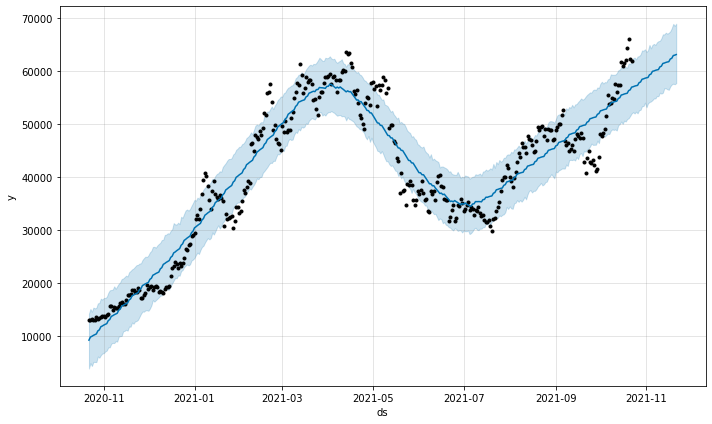

In [33]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

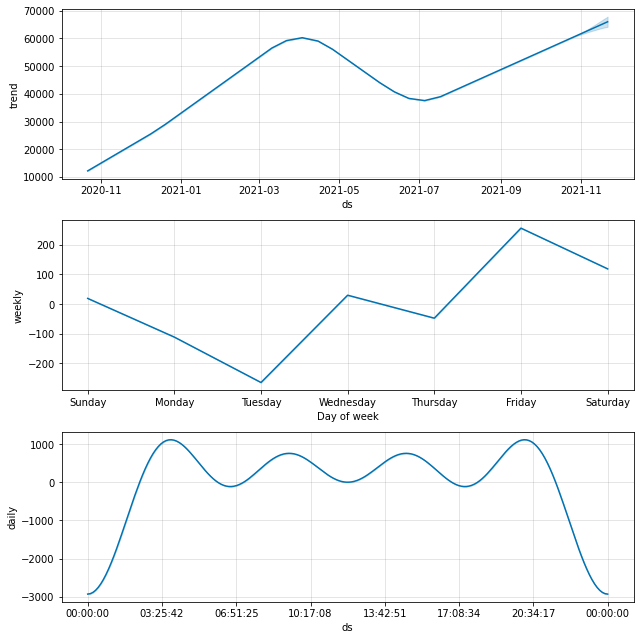

In [34]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [ ]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>